In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import anndata

from sklearn.neighbors import BallTree, KDTree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
from joblib import delayed, Parallel
import seaborn as sns

In [2]:
def compute_binned_values(dists, scores, min_d=0, max_d=100, bin_size=30):
    binned_mean = np.zeros(max_d-min_d-bin_size)
    binned_std = np.zeros(max_d-min_d-bin_size)
    scores = np.array(scores)
    for i in np.arange(min_d, max_d-bin_size):
        # find distances in this bin range
        idx = np.argwhere(np.logical_and(dists>i, dists<=(i+bin_size)))
        curr_scores = scores[idx.flatten().tolist()]
        binned_mean[i] = np.mean(curr_scores)#/len(idx)
        binned_std[i] = np.std(curr_scores)/np.sqrt(len(curr_scores))#/len(idx)
    binned_mean -= binned_mean.mean()
    binned_std -= binned_mean.mean()
    return binned_mean, binned_std
def identify_nearest_neighbors_with_dist(X,Y, min_dist=0):
    if X.shape[0] > 0 and Y.shape[0] > 0:
        kdtree = KDTree(Y)
        dists, ind = kdtree.query(X, k=2,return_distance=True)
        good_dists = np.zeros(len(dists))
        good_ind = np.zeros(len(ind))
        for i in range(dists.shape[0]):
            if dists[i,0] > 0: # remove duplicates
                good_dists[i] = dists[i,0]
                good_ind[i] = ind[i,0]
            else:
                good_dists[i] = dists[i,1]
                good_ind[i] = ind[i,1]
        #ind_X = np.hstack([[i]*len(ind[i]) for i in np.arange(len(ind)) if len(ind[i])>0])
        return good_dists, good_ind
    else:
        return np.array([])

def compute_celltype_obs_distance_correlation(A,cell_type_X, cell_type_Y, obs_key_X, batch_key='batchID', celltype_key1='subclass_label_transfer', celltype_key2='subclass_label_transfer'):
    all_obs_X = []
    all_dists_Y = []

    # Iterate over each unique batch
    for batch in A.obs[batch_key].unique():
        # Filter by batch
        batch_data = A[A.obs[batch_key] == batch]

        # Filter by cell types within the batch
        X = batch_data[batch_data.obs[celltype_key1] == cell_type_X]
        Y = batch_data[batch_data.obs[celltype_key2] == cell_type_Y]

        # Extract the observed variable and spatial coordinates
        obs_X = X.obs[obs_key_X]
        curr_X = X.obsm['spatial']
        curr_Y = Y.obsm['spatial']

        # Compute the distances and indices of nearest neighbors within the batch
        dists_Y, ind_Y = identify_nearest_neighbors_with_dist(curr_X, curr_Y)

        # Store the results
        all_obs_X.extend(obs_X.values)
        all_dists_Y.extend(dists_Y)

    return all_obs_X, all_dists_Y

In [3]:
adata = sc.read_h5ad('../../../Shapes/full_run/conflicts_correction/Microglial_Morphology/02_annotation/ABC_cleaned.h5ad')
adata_HQ = adata[adata.obs.subclass_label_confidence > 0.5]

adata_raw = adata_HQ.copy()
adata_raw.X = adata_raw.layers['counts']
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
#scale values because scoring
sc.pp.scale(adata_raw,max_value=10)

#adjusted values subclass label transfer, comparable to 0.8 non-adjusted
Cerebellum = adata_raw[(adata_raw.obs.Brain_Region == 'Cerebellum') & (adata_raw.obs.adjusted_subclass_label_confidence > 0.5)].copy()
Hippocampus = adata_raw[(adata_raw.obs.Brain_Region == 'Hippocampus')& (adata_raw.obs.adjusted_subclass_label_confidence > 0.5)].copy()

/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [4]:
# Granule cell influence score
interest = ['Cxcl2','Slamf9','Cdk2', 'Atp2a3', 'Arhgap5']


sc.tl.score_genes(Cerebellum, gene_list=['Cdk4','Rb1','Cdk2','Lmnb1','Mki67','Cdk6'], score_name='anti_senescence_score', use_raw=False)
sc.tl.score_genes(Hippocampus, gene_list=['Cdk4','Rb1','Cdk2','Lmnb1','Mki67','Cdk6'], score_name='anti_senescence_score', use_raw=False)

sc.tl.score_genes(Cerebellum,gene_list=interest,score_name='interest')
sc.tl.score_genes(Hippocampus,gene_list=interest,score_name='interest')

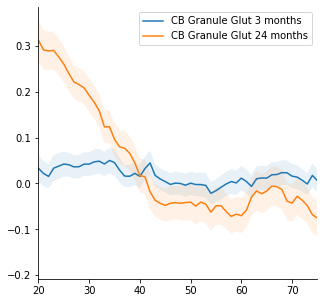

In [5]:
bin_size = 20
f = plt.figure(figsize=(5,5))
value = ['CB Granule Glut','CB Granule Glut']
ad_list = [Cerebellum, Cerebellum]
age_list = ['3','24']
j=0
for i in ad_list:
    scores, dists = compute_celltype_obs_distance_correlation(i[(i.obs.Age==age_list[j])], "Microglia NN", value[j], "anti_senescence_score")
    binned_mean, binned_std = compute_binned_values(dists, scores,bin_size=bin_size)
    x = np.arange(len(binned_mean))+bin_size
    plt.plot(x,binned_mean,label=value[j]+" "+age_list[j]+" months")
    plt.fill_between(x,binned_mean-binned_std, binned_mean+binned_std,alpha=0.1)
    j+=1
plt.legend()
plt.xlim([20, 75])
sns.despine()
plt.savefig('figures/division_cerebellum_microglia.pdf', bbox_inches='tight')

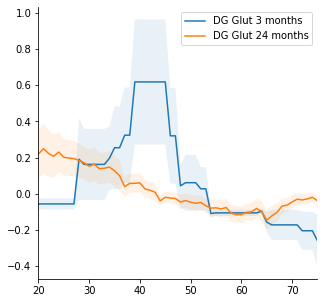

In [6]:
bin_size = 20
f = plt.figure(figsize=(5,5))
value = ['DG Glut','DG Glut']
ad_list = [Hippocampus, Hippocampus]
age_list = ['3','24']
j=0
for i in ad_list:
    scores, dists = compute_celltype_obs_distance_correlation(i[(i.obs.Age==age_list[j])], "Microglia NN", value[j], "anti_senescence_score")
    binned_mean, binned_std = compute_binned_values(dists, scores,bin_size=bin_size)
    x = np.arange(len(binned_mean))+bin_size
    plt.plot(x,binned_mean,label=value[j]+" "+age_list[j]+" months")
    plt.fill_between(x,binned_mean-binned_std, binned_mean+binned_std,alpha=0.1)
    j+=1
plt.legend()
plt.xlim([20, 75])
sns.despine()
plt.savefig('figures/division_hippocampus_microglia.pdf', bbox_inches='tight')

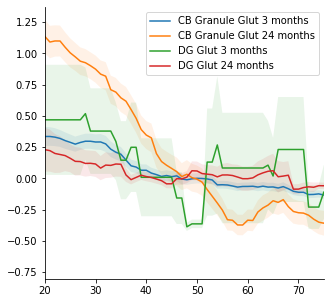

In [7]:
bin_size = 20
f = plt.figure(figsize=(5,5))
value = ['CB Granule Glut','CB Granule Glut', 'DG Glut','DG Glut']
ad_list = [Cerebellum, Cerebellum, Hippocampus,Hippocampus]
age_list = ['3','24','3','24']
j=0
for i in ad_list:
    scores, dists = compute_celltype_obs_distance_correlation(i[(i.obs.Age==age_list[j])], "Microglia NN", value[j], "interest")
    binned_mean, binned_std = compute_binned_values(dists, scores,bin_size=bin_size,max_d=100)
    x = np.arange(len(binned_mean))+bin_size
    plt.plot(x,binned_mean,label=value[j]+" "+age_list[j]+" months")
    plt.fill_between(x,binned_mean-binned_std, binned_mean+binned_std,alpha=0.1)
    j+=1
plt.legend()
plt.xlim([20, 75])
sns.despine()
plt.savefig('figures/Granule_microglia_score.pdf', bbox_inches='tight')